# Formula One Project: Final Report

DUE: December 10th, 2024 (Tue)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description
This is your final report! Consider the scenario of you giving a report to a client or your supervisor on your study. Include good reporting techniques. Use good tables and other visualizations. Structure your notebook using proper headers for major sections. THIS NOTEBOOK SHOULD BE A COMPLETE STANDALONE NOTEBOOK FROM START TO FINISH! But, ONLY INCLUDE THE BEST OUTCOMES FROM YOUR PREVIOUS NOTEBOOKS!

Include the following sections:

1. **Introduction**
   - This should have mostly been done in your first notebook. Just copy over relevant cells from your first part of the project, and add any new information you have learned. Your aim is to motivate the reader with the importance and relevance of your project.

2. **Data**
   - Again, most of this was likely done in your first part of the project. So, feel free to copy the important cells over.
   - After your introduction, you should be introducing the original, raw data. Where was it collected? When? How? Explain the meaning of the variables. What does each observation represent? And be sure to explain the key target variable (assuming you are doing classification/regression).
   - PLEASE DO NOT SHOW PAGES AND PAGES OF YOUR DATA! Display only a few observations so that the reader can see what your raw, original data look like.

3. **Data Preparation**
   - While the previous section shows the raw data, this section is going to carefully explain the steps you followed to clean and preprocess the data in a form suitable for analysis, visualization, and modeling. You should be setting proper variable types, dealing with missing data, etc. Preprocessing steps should be explained with justification. Include any dimensionality reduction techniques you might have done. Summarize what you needed to do to clean it, and show some example observations from your final, cleaned data.

4. **EDA**
   - We expect good EDA to understand your data. Visualizations after preprocessing will do far more to convey your summary statistics than just numbers. Discuss the distributions, correlations with the target variable, etc.

5. **Modeling**
   - What modeling methods did you try? And, which method(s) did you ultimately determine were the best? What hyperparameters were selected? Justify the selection of parameters. (i.e., did you do a grid search? You cannot simply say, "XGBoost was the only one I evaluated, and I used default parameters." Boring, and unlikely to obtain the best results. You are expected to evaluate different models and different hyperparameters. It is very rare that default parameters are the best in machine learning.)

6. **Performance Results**
   - Once you've selected the best model, clearly convey the results of your model. I expect to see ROC curves, precision/recall curves, confusion matrices, tables with prediction performance by class, (or, if regression, use appropriate regression measures), etc.

7. **Discussion**
   - Reflect on your project. For example: discuss any challenges you had with cleaning and preparing the data. Did you find any surprises during your modeling? Compare and contrast the methods and hyperparameters you evaluated. And, it's often useful to discuss the features that you thought were the most predictive, and those that were least useful. (Search for feature importance scikit-learn for more info!) Any info that might be of interest to me related to your project goes here.

8. **Conclusions**
   - Write a short summary of your project goes here.

In [7]:
# Importing Libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
#print versions of libraries
print(f'Python version: {sys.version}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {plt.matplotlib.__version__}')
print(f'Seaborn version: {sns.__version__}')
print(f'FastF1 version: {fastf1.__version__}')
print(f'Scikit-learn version: {sys.modules["sklearn"].__version__}')
print(f'XGBoost version: {xgb.__version__}')

Python version: 3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]
Pandas version: 2.2.2
Numpy version: 1.23.5
Matplotlib version: 3.8.4
Seaborn version: 0.13.2
FastF1 version: 3.4.4
Scikit-learn version: 1.5.1
XGBoost version: 2.1.1


## Problem Statement
We are analyzing Formula One driver performance to understand and predict race outcomes based on various conditions. Specifically, we aim to:
1. Predict lap times based on weather and track conditions
2. Understand how different variables affect driver performance
3. Create models that can forecast race performance

This is primarily a regression problem, as we're predicting continuous values (lap times) based on multiple features.

In [8]:
# Set up FastF1 plotting and caching
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)

In [9]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'British Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'São Paulo Grand Prix'] 

## Why these events, sessions, and years?

These events were chosen because they are all currently scheduled for the 2024 season, as well as having occurred in previous years. 

Each event has a specific set of conditions that may affect driver performance:
- Bahrain: Hot and humid, with high track temperatures
- British: Cool and changeable, with frequent rain
- United States: Very hot, with high track temperatures
- Mexico City: Cool and changeable, with frequent rain
- São Paulo: Hot and humid, with high track temperatures and heavy rain

As for years, we chose 2021 to 2024 because they are the most recent years for which data is available. In 2021, the regulations changed to allow for more overtaking, so the lap times became incomparable to that of previous years.

We chose to only use the 'Race' session because it is the most representative of a race condition, as opposed to qualifying, which can be very sporadic.

In [10]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

#Quick Test
years = [2021]
events = ['Bahrain Grand Prix']


# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    
if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)

Processing 2021 Bahrain Grand Prix - Race


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']


## Data Description
Our data comes from the FastF1 API, which provides detailed Formula One racing data. Each observation represents a single lap during a race or qualifying session, including:

Key Variables:
- **Time**: Timestamp of the lap
- **Driver**: Driver identifier
- **LapTime**: Time taken to complete the lap
- **Weather Conditions**:
  - TrackTemp: Track temperature in Celsius
  - AirTemp: Air temperature in Celsius
  - Humidity: Percentage
  - Rainfall: Boolean indicating presence of rain
- **Performance Metrics**:
  - Sector times (1,2,3)
  - Speed measurements at various points
  - Compound: Tire compound used
  - TyreLife: Age of tires in laps

Each lap is represented as a fixed-length vector containing these attributes, making it suitable for machine learning algorithms.

In [14]:
# Display a sample of the raw data
lap_data_combined.head()

,Time,Year,Event,Session,Driver,Team,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,FreshTyre,SpeedI1,SpeedI2,SpeedFL,SpeedST,LapTime_seconds
1,2021-01-01 00:41:37.134,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,2.0,0 days 00:02:22.263000,0 days 00:00:45.220000,0 days 00:01:00.086000,0 days 00:00:36.957000,MEDIUM,5.0,False,120.0,134.0,182.0,236.0,142.263
4,2021-01-01 00:48:28.044,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,5.0,0 days 00:02:11.534000,0 days 00:01:05.748000,0 days 00:00:41.956000,0 days 00:00:23.830000,HARD,1.0,True,231.0,251.0,275.0,213.0,131.534
5,2021-01-01 00:50:04.721,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,6.0,0 days 00:01:36.677000,0 days 00:00:30.990000,0 days 00:00:41.802000,0 days 00:00:23.885000,HARD,2.0,True,233.0,254.0,275.0,280.0,96.677
6,2021-01-01 00:51:41.675,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,7.0,0 days 00:01:36.954000,0 days 00:00:31.176000,0 days 00:00:41.678000,0 days 00:00:24.100000,HARD,3.0,True,232.0,252.0,274.0,282.0,96.954
8,2021-01-01 00:54:56.129,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,9.0,0 days 00:01:37.030000,0 days 00:00:31.256000,0 days 00:00:41.911000,0 days 00:00:23.863000,HARD,5.0,True,234.0,248.0,276.0,286.0,97.030


## Data Preprocessing Steps
1. Time Conversion:
   - Converting lap times from timedelta to seconds
   - Standardizing timestamps for weather correlation

2. Missing Value Handling:
   - Removing incomplete laps
   - Handling missing weather data

3. Feature Engineering:
   - Creating derived features from raw data
   - Normalizing numerical values

4. Data Integration:
   - Merging weather and lap data
   - Ensuring temporal alignment of measurements

In [11]:
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

In [12]:
# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

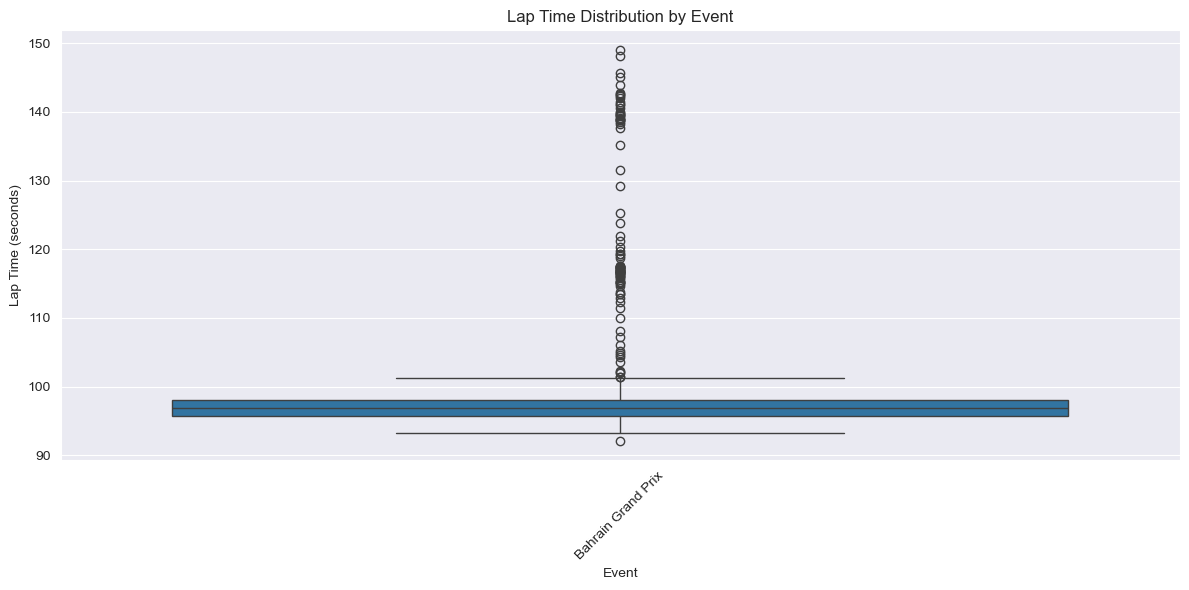

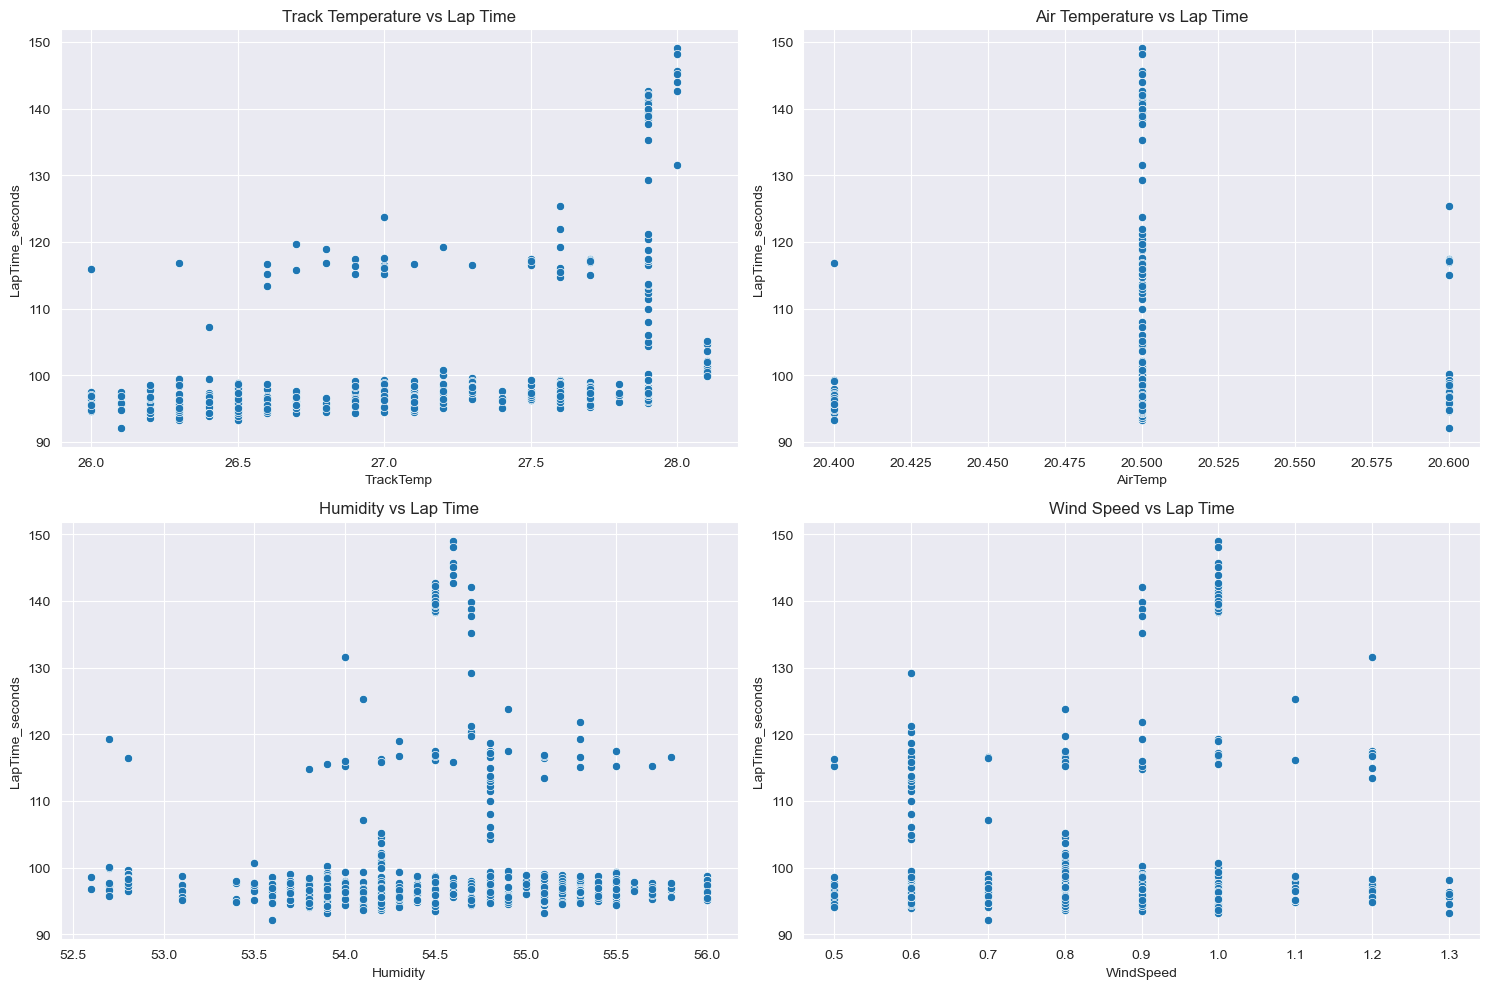

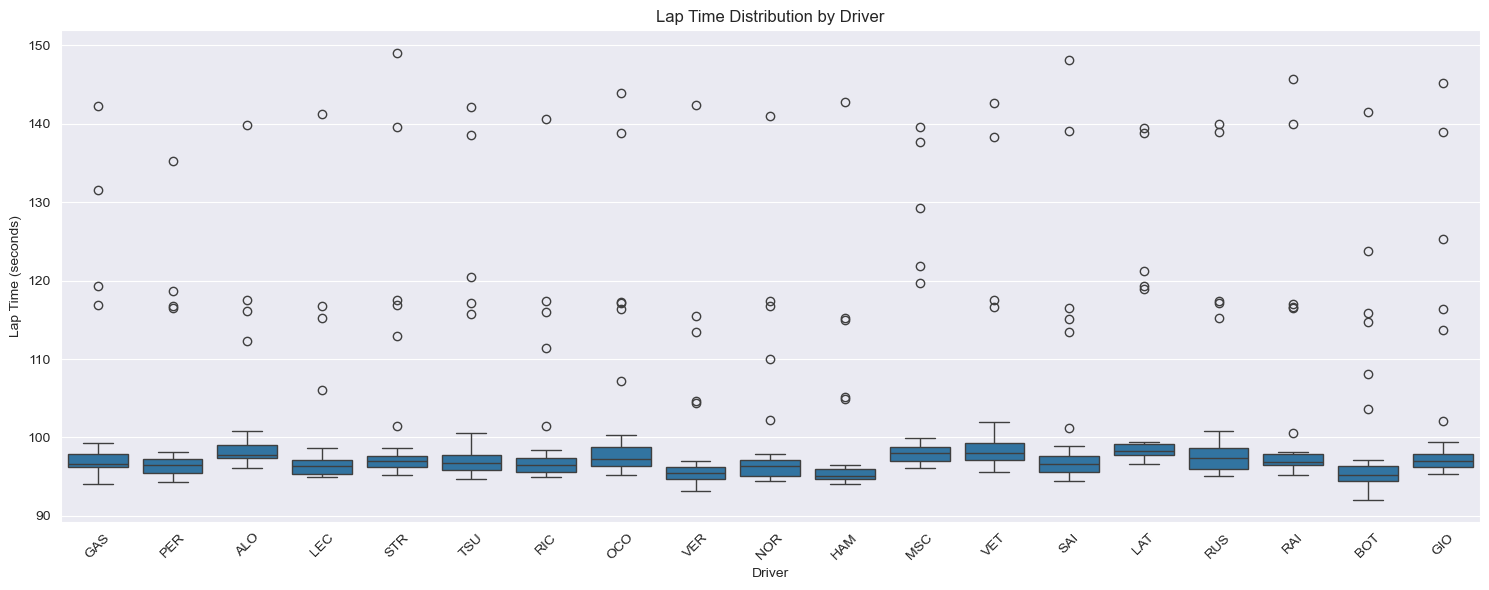

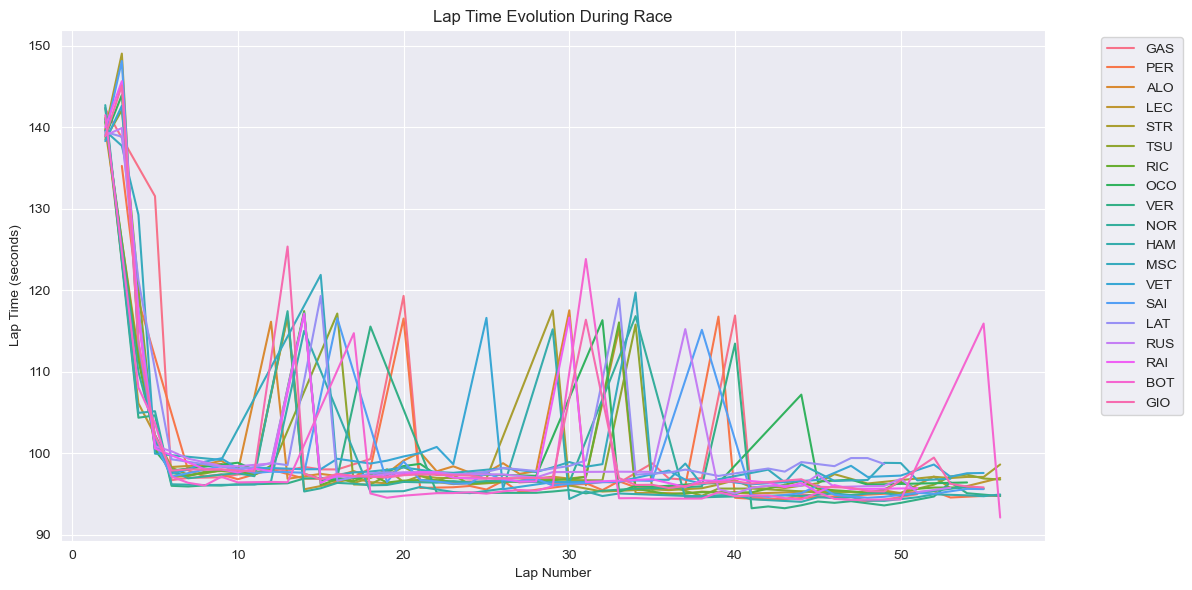

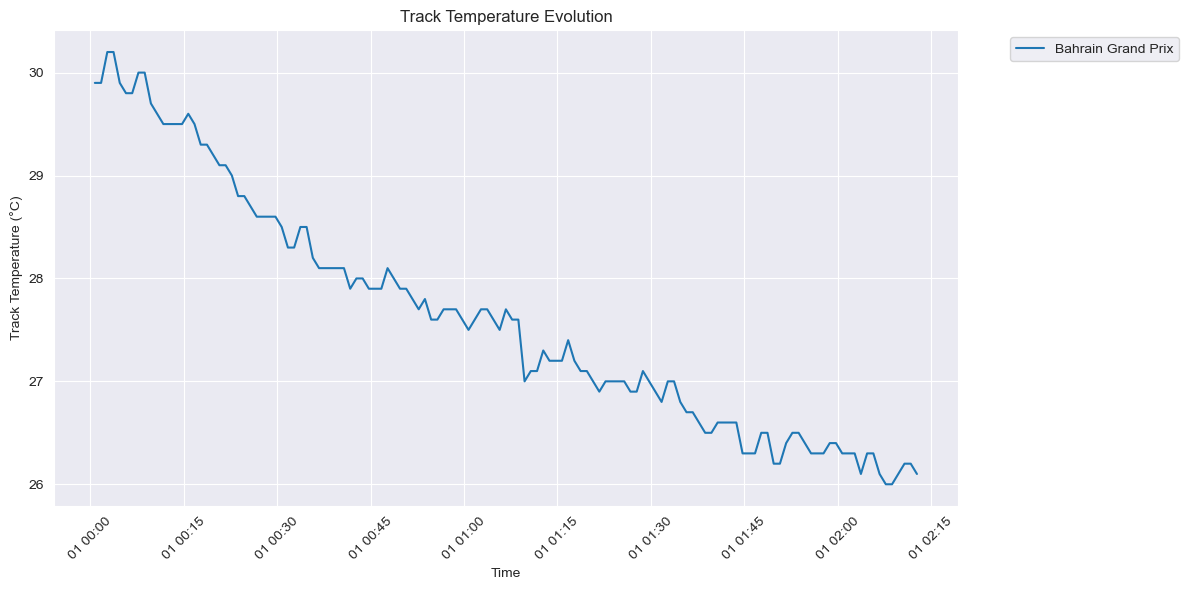

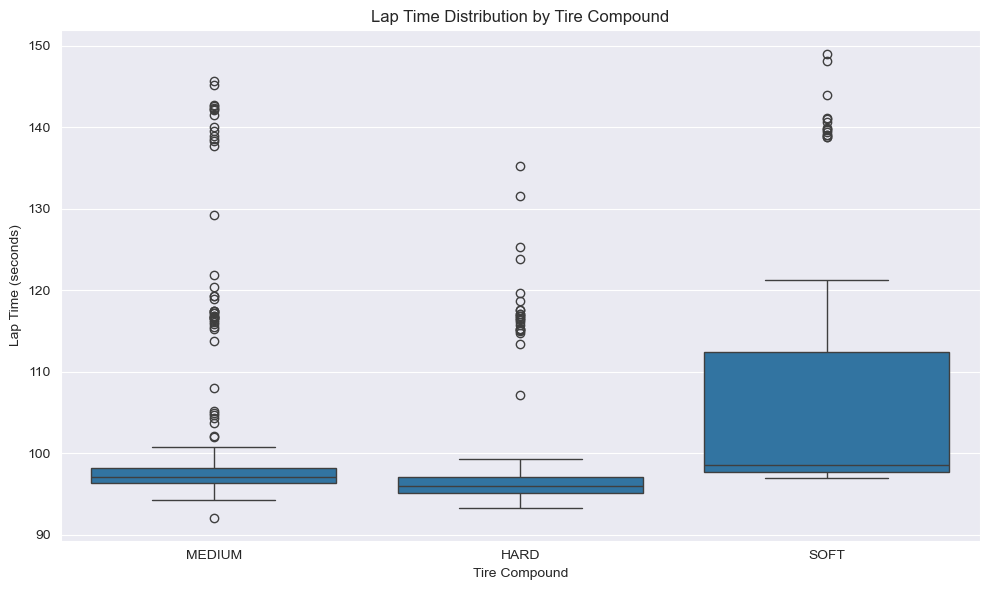

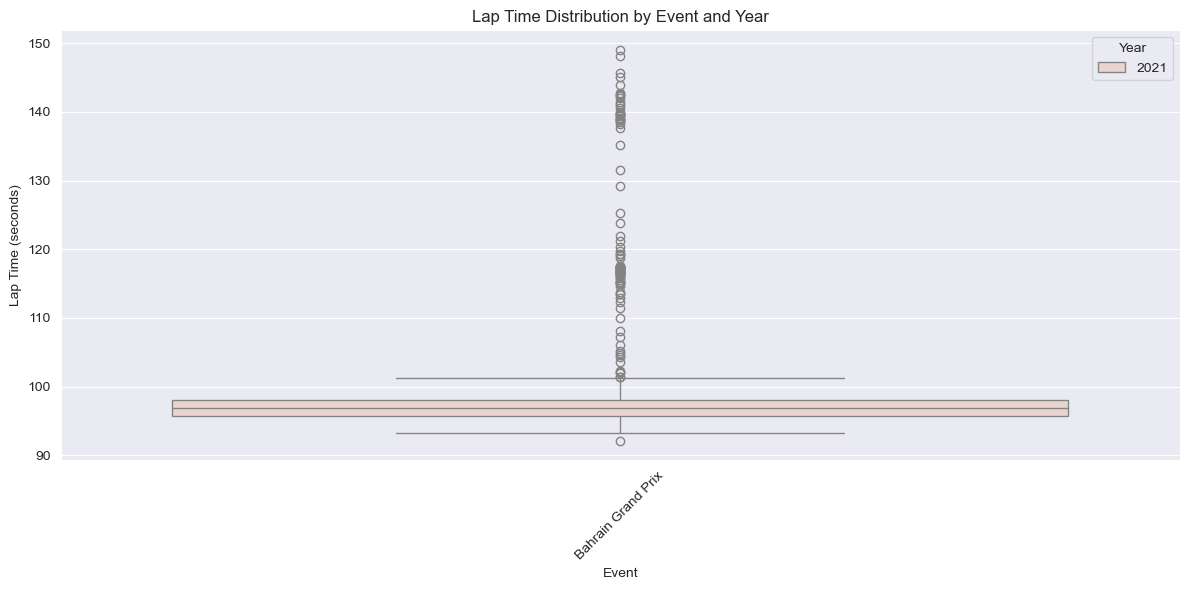

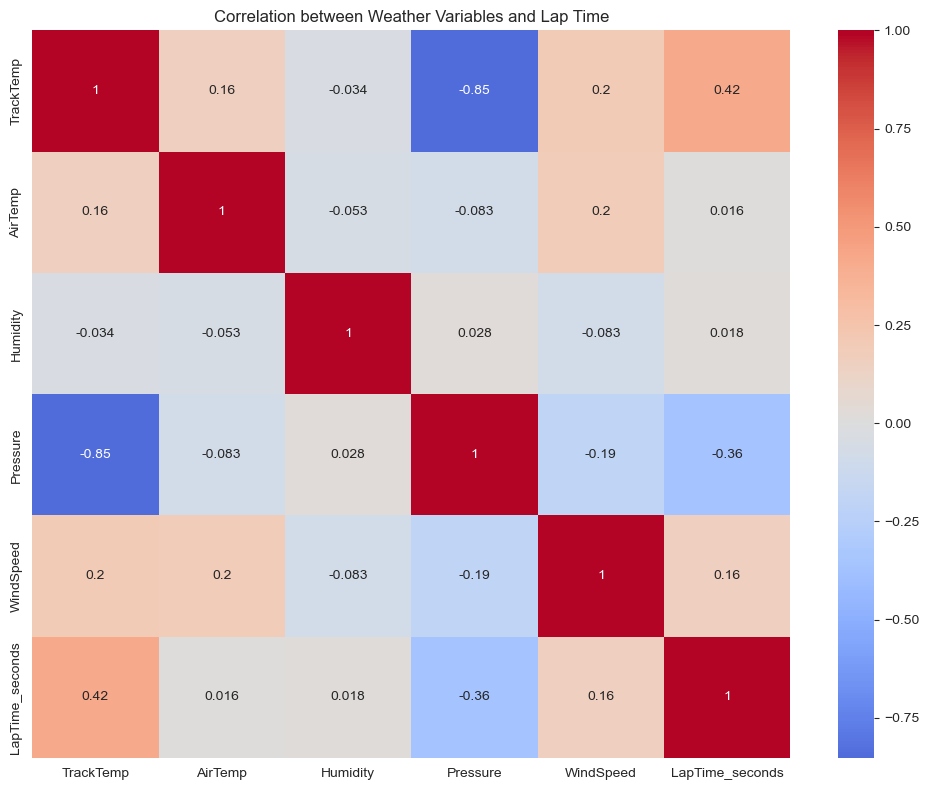

In [13]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = [12, 6]

# 1. Lap Time Distribution by Event
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 2. Weather Conditions Impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=merged_data, x='TrackTemp', y='LapTime_seconds', ax=axes[0,0])
axes[0,0].set_title('Track Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='AirTemp', y='LapTime_seconds', ax=axes[0,1])
axes[0,1].set_title('Air Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='Humidity', y='LapTime_seconds', ax=axes[1,0])
axes[1,0].set_title('Humidity vs Lap Time')

sns.scatterplot(data=merged_data, x='WindSpeed', y='LapTime_seconds', ax=axes[1,1])
axes[1,1].set_title('Wind Speed vs Lap Time')
plt.tight_layout()
plt.show()

# 3. Driver Performance Comparison
plt.figure(figsize=(15, 6))
sns.boxplot(data=lap_data_combined, x='Driver', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Driver')
plt.xlabel('Driver')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 4. Lap Time Evolution Over Race
plt.figure(figsize=(12, 6))
sns.lineplot(data=lap_data_combined, x='LapNumber', y='LapTime_seconds', hue='Driver')
plt.title('Lap Time Evolution During Race')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Track Temperature Changes
plt.figure(figsize=(12, 6))
sns.lineplot(data=weather_data_combined, x='Time', y='TrackTemp', hue='Event')
plt.title('Track Temperature Evolution')
plt.xlabel('Time')
plt.ylabel('Track Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Tire Compound Impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=lap_data_combined, x='Compound', y='LapTime_seconds')
plt.title('Lap Time Distribution by Tire Compound')
plt.xlabel('Tire Compound')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 7. Year-over-Year Comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds', hue='Year')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event and Year')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 8. Weather Correlation Heatmap
weather_vars = ['TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'WindSpeed', 'LapTime_seconds']
correlation = merged_data[weather_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Weather Variables and Lap Time')
plt.tight_layout()
plt.show()

## Modeling Approach
This is primarily a regression problem as we're predicting continuous lap times. We plan to use:

1. Basic Models:
   - Linear Regression (baseline)
   - Random Forest Regression
   - XGBoost

2. Advanced Techniques:
   - Cross-validation for model evaluation
   - Hyperparameter tuning



## Reasoning Behind Model Selection
In our project, we chose to use Linear Regression, Random Forest Regression, Gradient Boosting  and XGBoost for predicting lap times in Formula One races. The selection of these models is inspired by the comparative study presented in the paper "A Comparison of Regression Models for Prediction of Graduate Admissions" and "A Comparative Analysis of Gradient Boosting Algorithms".  Here is a brief description of why we chose each model:

### Linear Regression
Linear Regression is a fundamental and straightforward regression model that establishes a linear relationship between the dependent variable and one or more independent variables. According to the paper, Linear Regression performed well with a low Mean Squared Error (MSE) and a high R-squared score, indicating its effectiveness in capturing linear dependencies in the data. Given its simplicity and interpretability, we use Linear Regression as a baseline model for our predictions.

### Random Forest Regression
Random Forest Regression is an ensemble learning method that combines multiple decision trees to improve predictive performance. The paper highlights that Random Forest Regression performed closely to Linear Regression, with a slightly higher MSE but still a strong R-squared score. This model is particularly effective in handling non-linear interactions between features and is robust to overfitting. Therefore, we include Random Forest Regression to capture complex relationships in our data.

### Gradient Boosting

### XGBoost

Sources: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=
         https://link.springer.com/content/pdf/10.1007/s10462-020-09896-5.pdf?error=cookies_not_supported&code=efdc961b-c226-462a-806a-36e221a60632
         
